In [1]:
%load_ext autoreload
%autoreload 2
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import umap
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import StandardScaler
from cdlib import algorithms
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from scipy.stats import zscore
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import mannwhitneyu, ranksums
from sklearn.cluster import AgglomerativeClustering

sys.path.append("../funcs")
import utils
import plotting as pl
import nmf_utilities as nmu
import proteomics as prot

/home/yakiyama/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'wurlitzer', 'leidenalg', 'infomap', 'karateclub'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'karateclub', 'ASLPAw'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'infomap', 'wurlitzer', 'leidenalg'}


In [4]:
# File paths
MULTIOMIC_H_PATH = "../data/clustering/H_matrix_multiomic_nmf.tsv"
NMF_PHENO_MATRIX_PATH = "../data/clustering/multiomic_nmf_phenotype_matrix.tsv"
SAMPLE_MAP_PATH = "gs://cptac-pancan-getzlab/mapping/PanCan_Participant_freeze_mapping.tsv"
DENDROGRAM_MAP_PATH = "gs://cptac-pancan-getzlab/Freeze_061721/dendrogram/dendro_map_061721.tsv"
SUBTYPE_MAP_PATH = "gs://cptac-pancan-getzlab/Freeze_061721/dendrogram/dendro_map_with_subtype.tsv"
CLUSTER_MAP_PATH = "../data/clustering/mappings_pancan_102322.tsv"
H_MUT_PATH = "gs://cptac-pancan-getzlab/Freeze_061721/mutational_signatures/Full_H_compressed_v1.1.tsv"
COSINE_SIM_PATH = "../data/clustering/cosine_sim_H.tsv"
NMF_PATH = "../data/clustering/nmf_output.h5"

In [5]:
df = pd.read_csv(NMF_PHENO_MATRIX_PATH, sep='\t', index_col=0).set_index("Unnamed: 0.1")

In [6]:
df.index.map(lambda x: x.split('_n')[0]).nunique()

14057

In [7]:
# Load data
h_df = pd.read_csv(MULTIOMIC_H_PATH, sep='\t', index_col=0)
dendrogram_df = pd.read_csv(DENDROGRAM_MAP_PATH, sep='\t', index_col=0)
cluster_df = pd.read_csv(CLUSTER_MAP_PATH, sep='\t', index_col=0)
phenotype_df = pd.read_csv(NMF_PHENO_MATRIX_PATH, sep='\t', index_col=0).set_index("Unnamed: 0.1")
subtype_df = pd.read_csv(SUBTYPE_MAP_PATH, sep='\t', index_col=0)
h_mut_df = pd.read_csv(H_MUT_PATH, sep='\t', index_col=0)
sample_df = pd.read_csv(SAMPLE_MAP_PATH, sep='\t', index_col=0)
cosine_sim_df = pd.read_csv(COSINE_SIM_PATH, sep='\t', index_col=0)
h_raw_df = pd.read_hdf(NMF_PATH, "Hraw")

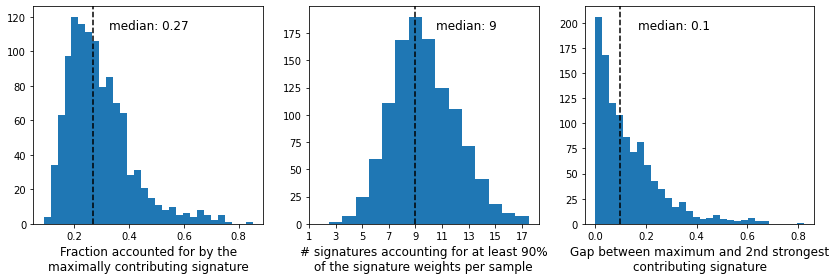

In [55]:
max_dist_f, max_dist_ax = plt.subplots(1, 3, figsize=(14,4))
h_df['max_norm'].hist(ax=max_dist_ax[0], bins=30)
max_dist_ax[0].set_xlabel("Fraction accounted for by the\nmaximally contributing signature", 
                          size=12)

h_norm_df = h_df.drop(columns=['max','max_id','max_norm'])
h_norm_df = h_norm_df.div(h_norm_df.sum(1), 0)
h_norm_df.apply(lambda x: (x.sort_values(ascending=False).cumsum() <= 0.9).sum()+1, 
                1).hist(bins=15, ax = max_dist_ax[1], align='left')
median_nsigs_90perc = h_norm_df.apply(
    lambda x: (x.sort_values(ascending=False).cumsum() <= 0.9).sum()+1, 1).median()
max_dist_ax[1].set_xlabel(
    "# signatures accounting for at least 90%\nof the signature weights per sample",
    size=12)

# Gap between maximum and 2nd strongest contributing signature 
h_norm_df.apply(lambda x: x.sort_values(ascending=False)[0] - x.sort_values(ascending=False)[1], 
                1).hist(bins=30, ax=max_dist_ax[2])
max_dist_ax[2].set_xlabel("Gap between maximum and 2nd strongest\ncontributing signature", size=12)
max_dist_ax[0].grid(False)
max_dist_ax[1].grid(False)
max_dist_ax[2].grid(False)

max_dist_ax[1].set_xticks(range(1, 18, 2))

median_numSigs = h_norm_df.apply(
    lambda x: (x.sort_values(ascending=False).cumsum() <= 0.9).sum()+1, 1).median()
median_gap = h_norm_df.apply(
    lambda x: x.sort_values(ascending=False)[0] - x.sort_values(ascending=False)[1], 1).median()
max_dist_ax[0].axvline(x=h_df['max_norm'].median(), color='black', linestyle='--')
max_dist_ax[1].axvline(x=median_numSigs, color='black', linestyle='--')
max_dist_ax[2].axvline(x=median_gap, color='black', linestyle='--')
max_dist_f.text(s=f"median: {round(h_df['max_norm'].median(), 2)}", x = 0.2, y = 0.8, size=12)
max_dist_f.text(s=f"median: {int(median_numSigs)}", x = 0.525, y = 0.8, size=12)
max_dist_f.text(s=f"median: {round(median_gap, 2)}", x = 0.725, y = 0.8, size=12)
max_dist_f.savefig("../figures/cluster_samples/nmf_signature_distributions.pdf", dpi=100, bbox_inches='tight')

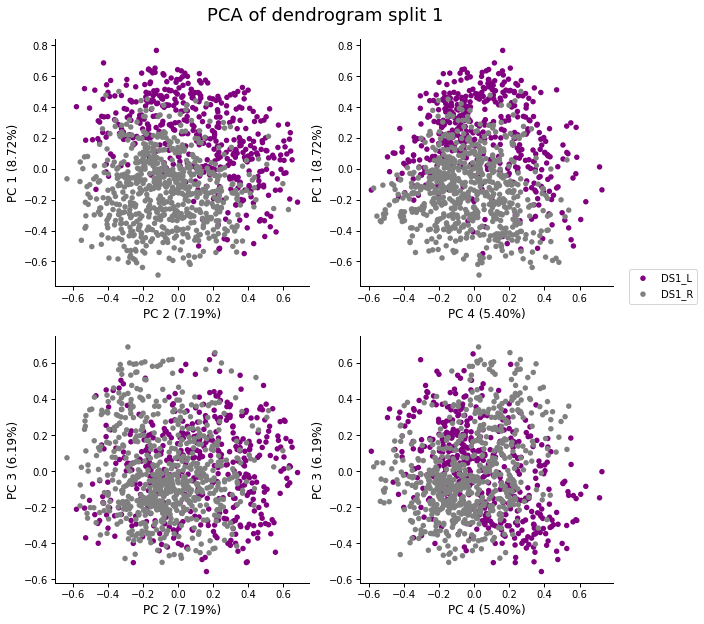

In [85]:
# Subset for Dendrogram Split 3, PCA using the signature weights, 
# and ranking the signatures based on their importance in PC1
# Color PCA by max signature
cluster_colors_d = {'DS1_L':'purple', 'DS1_R':'grey'}
h_raw_df =  h_df.loc[dendrogram_df.index].drop(columns=['max','max_id','max_norm'])
# h_raw_df = h_raw_df.div(h_raw_df.sum(1), 0)
clust_s = h_raw_df.apply(lambda x: cluster_df.to_dict()['PanCan_clusters_detailed'][x.name], 1)
clust_s = clust_s.map(lambda x: 'DS1_L' if x in ['C1', 'C2a', 'C2b'] else 'DS1_R')
h_raw_df = h_raw_df.T
h_raw_df = h_raw_df - h_raw_df.mean(axis=0)
h_raw_df = h_raw_df / np.sqrt(h_raw_df.pow(2).sum(axis=0))
P_df, pca, gns = utils.get_pcs(h_raw_df, normalize=False, return_genes=True, C=None)
fig, axes = pl.plot_pca_grid(
    h_raw_df, 
    normalize=False, 
    cohort_s=clust_s, 
    title='PCA of dendrogram split 1', 
    cohort_colors=cluster_colors_d, retFig=True)

[Text(0, 0, 'Dendrogram\nSplit 1 Left'),
 Text(1, 0, 'Dendrogram\nSplit 1 Right')]

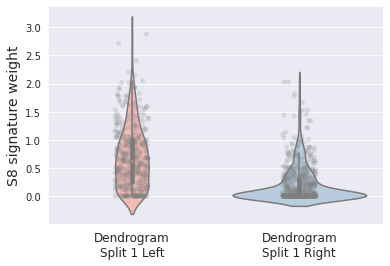

In [39]:
s8_df = h_raw_df.T[['S8']]
s8_df['Dendrogram Split 1 membership'] = s8_df.index.map(
    lambda x: 'Dendrogram Split 1 Left' if dendrogram_df.loc[x,'1']==True else 
    "Dendrogram Split 1 Right"
)
f, ax = plt.subplots(1, 1, figsize=(6,4))
sns.set_style("darkgrid")
sns.violinplot(data=s8_df, x='Dendrogram Split 1 membership', 
               y='S8', palette="Pastel1", 
               ax=ax)
sns.stripplot(data=s8_df, x='Dendrogram Split 1 membership', 
              y='S8', alpha=0.2, color='grey', 
              ax=ax)
ax.set_ylabel("S8 signature weight", size=14)
ax.set_xlabel("")
ax.axes.set_xticklabels(["Dendrogram\nSplit 1 Left", "Dendrogram\nSplit 1 Right"], size=12)

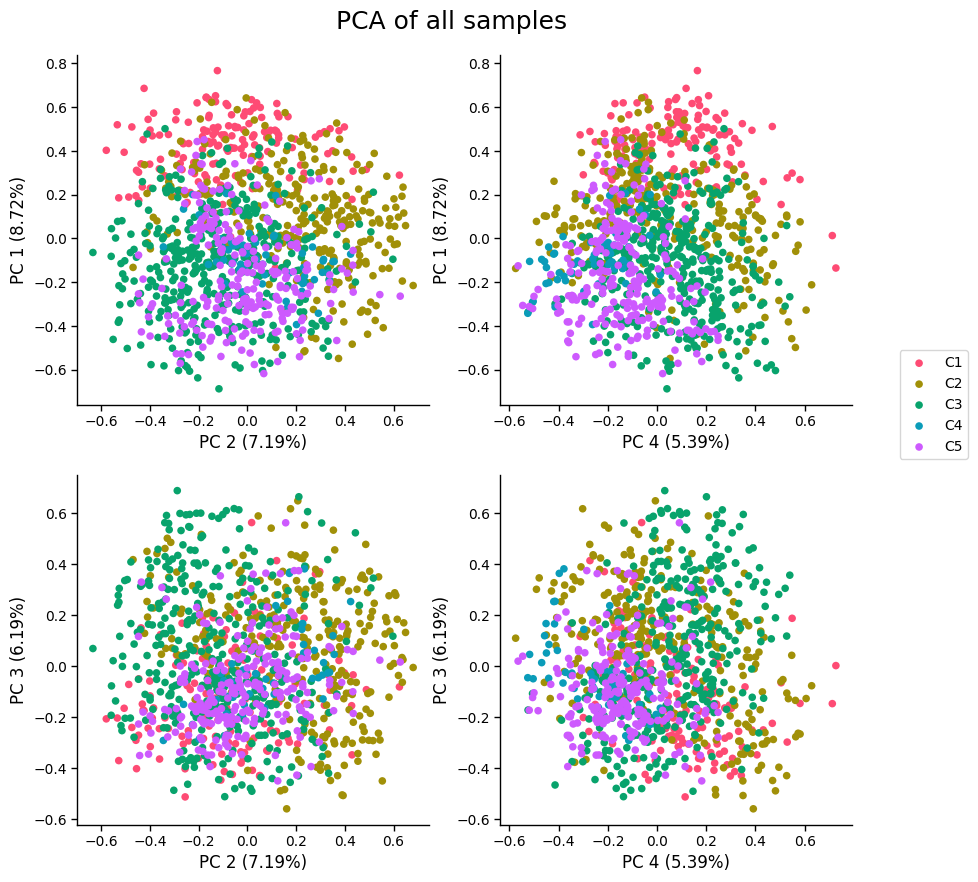

In [372]:
# Subset for Dendrogram Split 3, PCA using the signature weights, 
# and ranking the signatures based on their importance in PC1
# Color PCA by max signature
# cluster_colors_d = {'C1':'purple', 'DS1_R':'grey'}
h_raw_df =  h_df.loc[dendrogram_df.index].drop(columns=['max','max_id','max_norm'])
# h_raw_df = h_raw_df.div(h_raw_df.sum(1), 0)
clust_s = h_raw_df.apply(lambda x: cluster_df.to_dict()['PanCan_clusters'][x.name], 1)
# clust_s = clust_s.map(lambda x: 'DS1_L' if x in ['C1', 'C2a', 'C2b'] else 'DS1_R')
h_raw_df = h_raw_df.T
h_raw_df = h_raw_df - h_raw_df.mean(axis=0)
h_raw_df = h_raw_df / np.sqrt(h_raw_df.pow(2).sum(axis=0))
P_df, pca, gns = utils.get_pcs(h_raw_df, normalize=False, return_genes=True, C=None)
fig, axes = pl.plot_pca_grid(
    h_raw_df, 
    normalize=False, 
    cohort_s=clust_s, 
    title='PCA of all samples', 
    retFig=True)

In [438]:
pheno_pca_df =  phenotype_df.set_index('Unnamed: 0')
pheno_pca_df['phenotype_id'] = pheno_pca_df.index.map(lambda x: x.split('_n')[0])
pheno_pca_df = pheno_pca_df.groupby('phenotype_id').apply(
    lambda x: x.drop(columns=['phenotype_id']).sum())

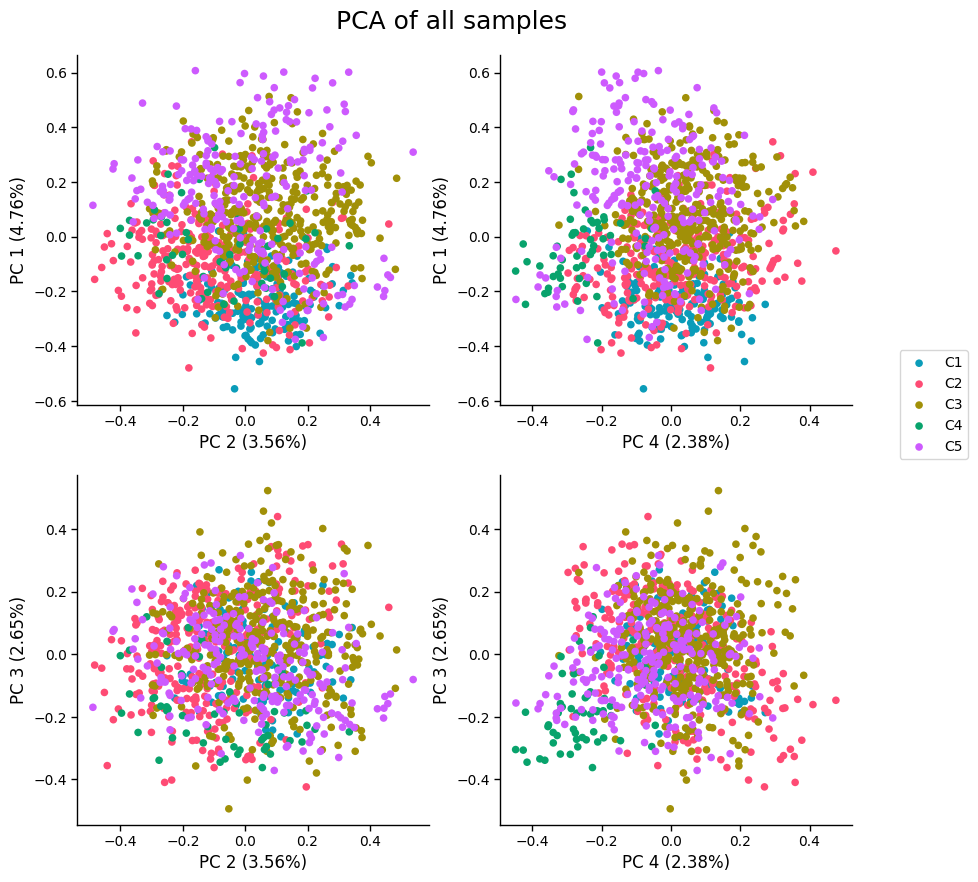

In [439]:
# Subset for Dendrogram Split 3, PCA using the signature weights, 
# and ranking the signatures based on their importance in PC1
# Color PCA by max signature
# cluster_colors_d = {'C1':'purple', 'DS1_R':'grey'}
clust_s = pheno_pca_df.apply(lambda x: cluster_df.to_dict()['PanCan_clusters'][x.name], 0)
pheno_pca_df = pheno_pca_df - pheno_pca_df.mean(axis=0)
pheno_pca_df = pheno_pca_df / np.sqrt(pheno_pca_df.pow(2).sum(axis=0))
P_df, pca, gns = utils.get_pcs(pheno_pca_df, normalize=False, return_genes=True, C=None)
fig, axes = pl.plot_pca_grid(
    pheno_pca_df, 
    normalize=False, 
    cohort_s=clust_s, 
    title='PCA of all samples', 
    retFig=True)

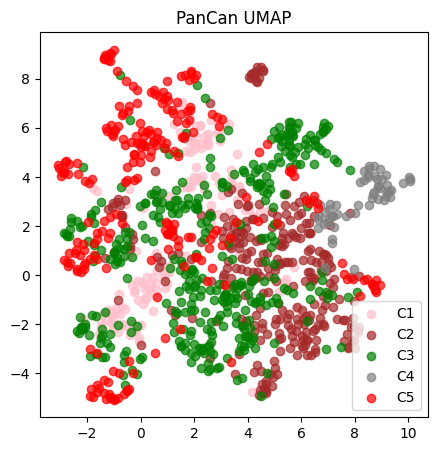

In [442]:
pancan_f, pancan_ax = plt.subplots(1, 1, figsize=(5,5))
reducer = umap.UMAP(n_neighbors=5, min_dist=0.5, random_state=10)
embedding = reducer.fit_transform(pheno_pca_df.T)
cluster_color_d = {'C1':'pink', 'C2':'brown', 'C3':'green', 'C4':'grey', 'C5':'red'}
clust_s = pheno_pca_df.T.apply(lambda x: cluster_df.to_dict()['PanCan_clusters'][x.name], 1)
clust_idx_df = clust_s.reset_index()
for cluster in sorted(clust_s.unique()):
    idx_clust = clust_idx_df[clust_idx_df[0]==cluster].index
    pancan_ax.scatter(
        embedding[idx_clust, 0],
        embedding[idx_clust, 1], 
        c = cluster_color_d[cluster],
        label=cluster, 
        alpha=0.7)
pancan_ax.set_title("PanCan UMAP")
pancan_ax.legend(loc="lower right")

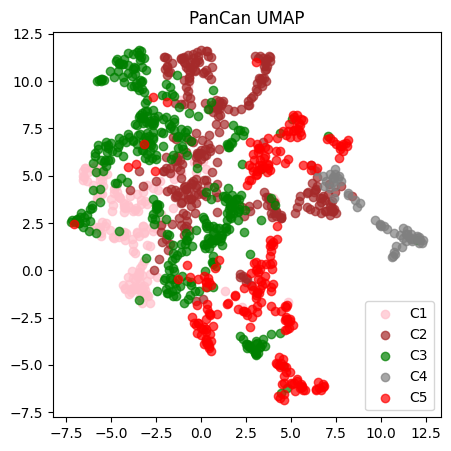

In [393]:
pancan_f, pancan_ax = plt.subplots(1, 1, figsize=(5,5))
reducer = umap.UMAP(n_neighbors=5, min_dist=0.5, random_state=10)
embedding = reducer.fit_transform(h_raw_df.T)
cluster_color_d = {'C1':'pink', 'C2':'brown', 'C3':'green', 'C4':'grey', 'C5':'red'}
clust_s = h_raw_df.T.apply(lambda x: cluster_df.to_dict()['PanCan_clusters'][x.name], 1)
clust_idx_df = clust_s.reset_index()
for cluster in sorted(clust_s.unique()):
    idx_clust = clust_idx_df[clust_idx_df[0]==cluster].index
    pancan_ax.scatter(
        embedding[idx_clust, 0],
        embedding[idx_clust, 1], 
        c = cluster_color_d[cluster],
        label=cluster, 
        alpha=0.7)
pancan_ax.set_title("PanCan UMAP")
pancan_ax.legend(loc="lower right")


[]

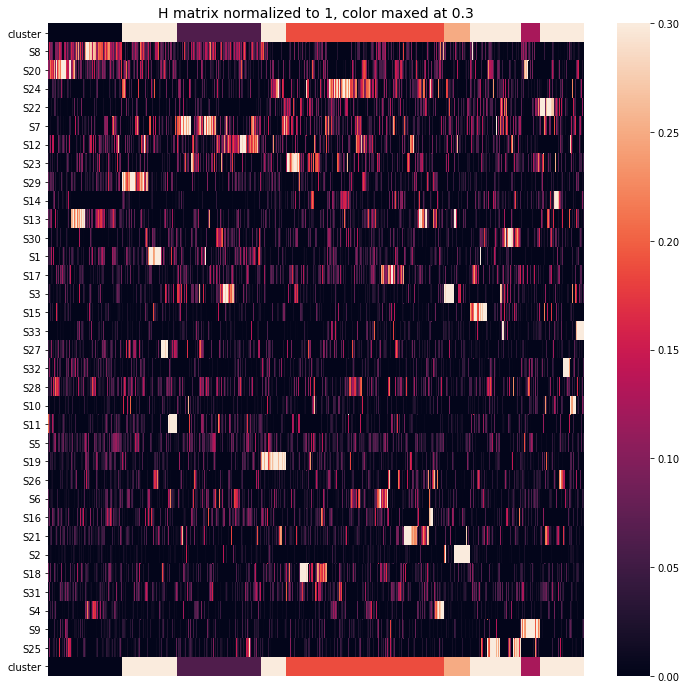

In [98]:
h_norm_df = h_df.loc[dendrogram_df.index].drop(columns=['max','max_id','max_norm'])
h_norm_df = h_norm_df.div(h_norm_df.sum(1), 0)
h_norm_df['cluster'] = h_norm_df.index.map(cluster_df.to_dict()['PanCan_clusters_detailed'])
clust_val_l = np.linspace(0, 0.5, 9)
clust_val_alt_l = []
even = 1
for i in range(len(clust_val_l)):
    if i % 2 == 0:
        if i:
            idx = i-1
        else:
            idx = i
    else:
        idx = i
    clust_val_alt_l.append(clust_val_l[idx*even])
    even *= -1
cluster_l = h_norm_df['cluster'].unique()
cluster_val_d = {cluster_l[i]:clust_val_alt_l[i] for i in range(len(cluster_l))}
h_norm_df['cluster'] = h_norm_df['cluster'].map(cluster_val_d)

# sig_order_l = [24, 22, 7, 23, 14, 30, 17]
sig_order_l = ['cluster'] + ['S' + str(sig+1) for sig in rank_sigs_arr][::-1] + ['cluster']
heatmap_f, heatmap_ax = plt.subplots(1, 1, figsize=(12,12))
sns.heatmap(h_norm_df.T.loc[sig_order_l], ax=heatmap_ax, vmax=0.3)
heatmap_ax.set_title("H matrix normalized to 1, color maxed at 0.3", size=14)
heatmap_ax.set_xticks([])

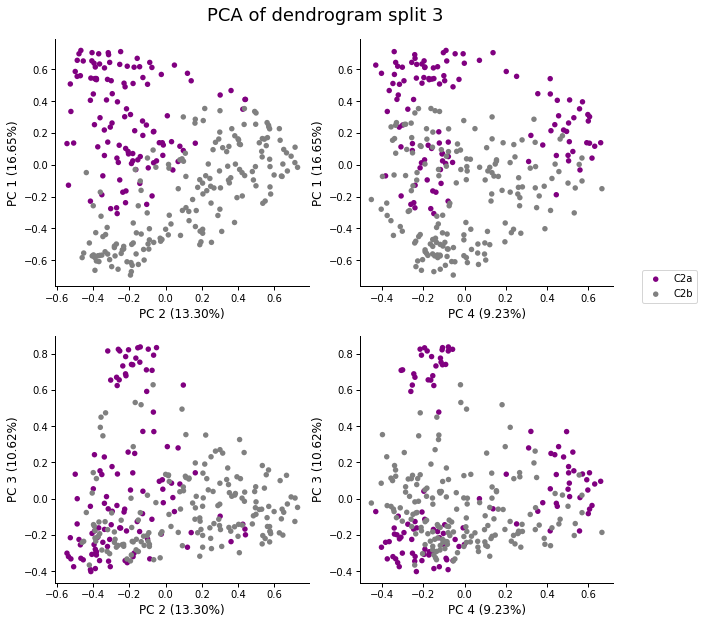

In [126]:
# Subset for Dendrogram Split 3, PCA using the signature weights, 
# and ranking the signatures based on their importance in PC1
# Color PCA by max signature
cluster_colors_d = {'C2a':'purple', 'C2b':'grey'}
h_raw_df =  h_df.loc[dendrogram_df.index].drop(columns=['max','max_id','max_norm'])
h_raw_df = h_raw_df[h_raw_df.index.map(cluster_df.to_dict()['PanCan_clusters'])=='C2']
cluster_s = h_raw_df.apply(lambda x: cluster_df.to_dict()['PanCan_clusters_detailed'][x.name], 1)
h_raw_df = h_raw_df.T
h_raw_df = h_raw_df - h_raw_df.mean(axis=0)
h_raw_df = h_raw_df / np.sqrt(h_raw_df.pow(2).sum(axis=0))
P_df, pca, gns = utils.get_pcs(h_raw_df, normalize=False, return_genes=True, C=None)
fig, axes = pl.plot_pca_grid(
    h_raw_df, 
    normalize=False, 
    cohort_s=cluster_s, 
    title='PCA of dendrogram split 3', 
    cohort_colors=cluster_colors_d, retFig=True)

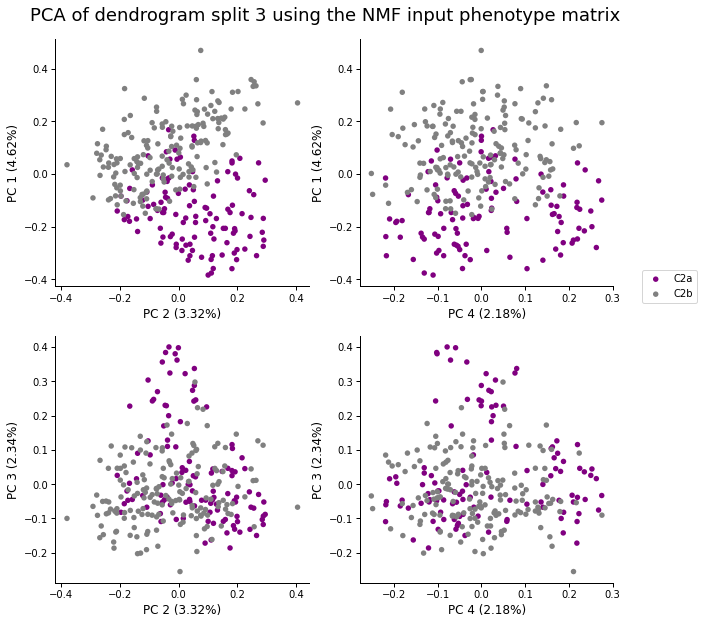

In [131]:
# PCA using NMF input
cluster_colors_d = {'C2a':'purple', 'C2b':'grey'}
c2_samples_l = h_df[h_df.index.map(cluster_df.to_dict()['PanCan_clusters'])=='C2'].index
subset_pheno_df = phenotype_df[c2_samples_l]
subset_pheno_df = subset_pheno_df - subset_pheno_df.mean(axis=0)
subset_pheno_df = subset_pheno_df / np.sqrt(subset_pheno_df.pow(2).sum(axis=0))
P_df, pca, gns = utils.get_pcs(subset_pheno_df, normalize=False, return_genes=True, C=None)
fig, axes = pl.plot_pca_grid(
    subset_pheno_df, 
    normalize=False, 
    cohort_s=subset_pheno_df.apply(lambda x: cluster_df.to_dict()['PanCan_clusters_detailed'][x.name]), 
    title='PCA of dendrogram split 3 using the NMF input phenotype matrix', 
    cohort_colors=cluster_colors_d, retFig=True)

In [ ]:
squamous_samples_l = dendrogram_df[~dendrogram_df['13'].isna() 
                                   & (dendrogram_df['13']==True)].index
breast_samples_l = dendrogram_df[~dendrogram_df['13'].isna() 
                                 & (dendrogram_df['13']==False)
                                 & (dendrogram_df['19']==False)].index
luad_samples_l = dendrogram_df[~dendrogram_df['13'].isna() 
                                 & (dendrogram_df['13']==False)
                                 & (dendrogram_df['19']==True)].index

In [197]:
subtype_df.loc[squamous_samples_l].groupby(['subtype', 'cohort']).size().unstack(fill_value=0)

cohort,HNSCC,LSCC,LUAD,UCEC
subtype,,,,
Atypical,5,0,0,0
Basal,0,2,0,0
CNV-low,0,0,0,1
Classical,11,33,0,0
Proximal-inflammatory,0,0,1,0
unknown,0,1,0,0


In [198]:
subtype_df.loc[breast_samples_l].groupby([s'subtype', 'cohort']).size().unstack(fill_value=0)

cohort,BRCA
subtype,
Basal,25
Her2,1


In [199]:
subtype_df.loc[luad_samples_l].groupby(['subtype', 'cohort']).size().unstack(fill_value=0)

cohort,HNSCC,LSCC,LUAD
subtype,,,
Atypical,4,0,0
Classical,3,0,0
Mesenchymal,2,0,0
Proximal-proliferative,0,0,17
primitive,0,6,0
secretory,0,1,0


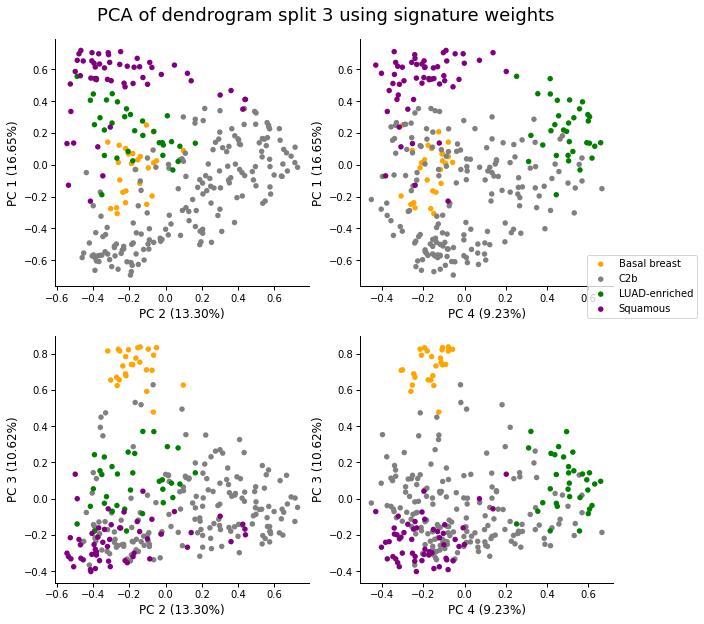

In [211]:
# Subset for Dendrogram Split 3, PCA using the signature weights, 
# and ranking the signatures based on their importance in PC1
# Color PCA by max signature
cluster_colors_d = {'Squamous':'purple', 'Basal breast':'orange', 'LUAD-enriched':'green',
                    'C2b':'grey'}
h_norm_df =  h_df.loc[dendrogram_df.index].drop(columns=['max','max_id','max_norm'])
h_norm_df = h_norm_df[h_norm_df.index.map(cluster_df.to_dict()['PanCan_clusters'])=='C2']
h_norm_df = h_norm_df.div(h_norm_df.sum(1), 0)
cluster_s = h_norm_df.apply(lambda x: 'Squamous' if x.name in squamous_samples_l 
                            else ('Basal breast' if x.name in breast_samples_l 
                                  else ('LUAD-enriched' if x.name in luad_samples_l 
                                        else 'C2b')), 1)
P_df, pca, gns = utils.get_pcs(h_norm_df.T, normalize=False, return_genes=True, C=None)
fig, axes = pl.plot_pca_grid(
    h_norm_df.T, 
    normalize=False, 
    cohort_s=cluster_s, 
    title='PCA of dendrogram split 3 using signature weights', 
    cohort_colors=cluster_colors_d, retFig=True)

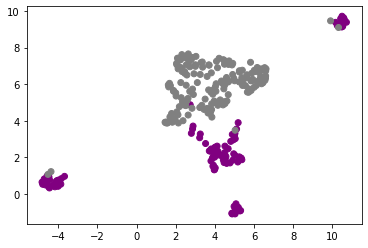

In [114]:
# UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(h_raw_df)
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c = h_raw_df.apply(lambda x: cluster_df.to_dict()['PanCan_clusters_detailed'][x.name], 
                       1).map(cluster_colors_d))


## 2. Define clusters using a dendrogram

In [8]:
# Cosine similarity between clusters
corr_raw_df = pd.DataFrame(cosine_similarity(h_raw_df.T), index=h_raw_df.columns, columns=h_raw_df.columns)

# Cohort dataframe
meta = sample_df.set_index('Proteome_Sample_ID')['cohort'].loc[corr_raw_df.columns]
meta.name = 'cohort'

In [9]:
def ss_linkage_groups(C, h_norm_df, lim=40, verbose=False):
    """
    Get groupings for each tree cut.
    """
    res = {}
    split_significant_sigs_d = {}
    def R(X, i, h_norm_df, lim=lim):
        """Recurse."""
        check_sigs = False
        if np.unique(X[i]).shape[0]==2:
            check_sigs = True
            ### Different most frequent maximally occuring signature
            significant_sigs_l = []
            split_val = X[i].unique()[0]
            group1_l = X[i][X[i]==split_val].index
            group2_l = X[i][X[i]!=split_val].index
            group1_df = h_norm_df.loc[group1_l]
            group2_df = h_norm_df.loc[group2_l]
            max_group1 = group1_df.apply(lambda x: x.argmax()+1, 1).value_counts().index[0]
            max_group2 = group2_df.apply(lambda x: x.argmax()+1, 1).value_counts().index[0]
            if ((max_group1 != max_group2) and (group1_df.shape[0] >= lim) and (group2_df.shape[0] >= lim)):
                if verbose:print("level {} | tot = {}".format(i, X.shape),X.groupby(i).size())
                res[i] = X[[i]]
                split_significant_sigs_d[i] = [max_group1, max_group2]
                significant_sigs_l = [max_group1, max_group2]
            if ((group1_df.shape[0] <= lim) or (group2_df.shape[0] <= lim)):
                pass
            
        # Add condition here to compare the two groups 
        if (((X.shape[0]==1) or (X.shape[0]<=lim)) or (check_sigs and (len(significant_sigs_l)==0))):
            pass
        else:
            for idx in np.unique(X[i]):
                R(X[X[i]==idx],i+1,h_norm_df)

    # Run
    R(C,1,h_norm_df)

    rename = dict()
    print("  * {} group comparisons".format(len(res.keys())))

    res_df = list()
    for x in res.keys():
        u = np.unique(res[x].iloc[:,0].dropna().copy())
        rename[u[0]] = True
        rename[u[1]] = False
        res_df.append(res[x].applymap(lambda x: rename[x]))
    res_df = pd.concat(res_df,1)
    #return pd.concat([res[x] for x in res.keys()],1)
    return res_df, split_significant_sigs_d

In [10]:
h_norm_df = h_df.drop(columns=['max', 'max_id', 'max_norm'])
h_norm_df = h_norm_df.div(h_norm_df.sum(1),0)
C = prot.ss_linkage_cut(corr_raw_df)
groups_df, split_significant_sigs_d = ss_linkage_groups(C, h_norm_df, verbose=True, lim=7)


level 1 | tot = (1110, 1110) 1
0    442
1    668
dtype: int64
level 3 | tot = (442, 1110) 3
0    154
2    288
dtype: int64
level 17 | tot = (154, 1110) 17
0    106
9     48
dtype: int64
level 22 | tot = (106, 1110) 22
0    78
4    28
dtype: int64
level 5 | tot = (288, 1110) 5
2    175
4    113
dtype: int64
level 11 | tot = (175, 1110) 11
3    82
5    93
dtype: int64
level 24 | tot = (93, 1110) 24
7     56
12    37
dtype: int64
level 13 | tot = (113, 1110) 13
9     54
10    59
dtype: int64
level 19 | tot = (59, 1110) 19
14    33
19    26
dtype: int64
level 27 | tot = (33, 1110) 27
19    17
23    16
dtype: int64
level 2 | tot = (668, 1110) 2
1    378
2    290
dtype: int64
level 6 | tot = (378, 1110) 6
1    326
4     52
dtype: int64
level 9 | tot = (326, 1110) 9
1    242
5     84
dtype: int64
level 10 | tot = (242, 1110) 10
1    191
2     51
dtype: int64
level 14 | tot = (191, 1110) 14
1     81
4    110
dtype: int64
level 18 | tot = (81, 1110) 18
1     54
16    27
dtype: int64
level 28 | 

In [11]:
groups_df.apply(lambda x: x.dropna().sort_index(ascending=False).index[0], 1).value_counts()

22    106
24     93
23     84
11     82
25     57
12     54
13     54
6      52
10     51
17     48
8      39
15     37
27     33
35     31
31     30
34     30
18     27
30     27
52     27
21     26
19     26
28     23
64     23
51     19
32     16
26     15
dtype: int64

In [14]:
d_linkage = shc.linkage(corr_raw_df, metric='euclidean', method='ward')
dres = shc.dendrogram(d_linkage, p=30, no_plot=True)

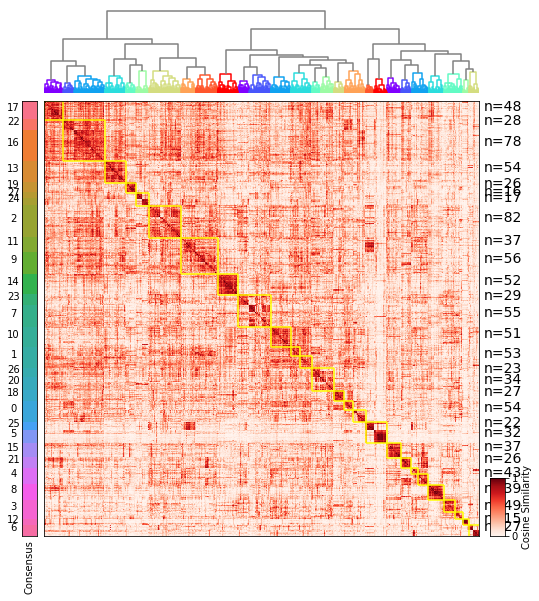

In [18]:
N_CLUSTERS = 28
f,d,dres,d_linkage = pl.plot_cmatrix(
    corr_raw_df, 
    n_clusters=N_CLUSTERS, 
    metas=None,
    vmax=1,
    cbar_label='Cosine Similarity',
    metric='euclidean',
    method='ward',
    cmap='Reds',
    plot_cluster_lines=True,
    show_xlab=False,
    cdict_force={True:'lightpink', False:'lightblue', -1:'white'},
    input_clusters = np.array(groups_df.apply(lambda x: x.dropna().sort_index(ascending=False).index[0], 
                                              1).iloc[dres['leaves']].to_list())
)
plt.savefig("Figures/FigS2B.pdf", dpi=100, bbox_inches='tight')

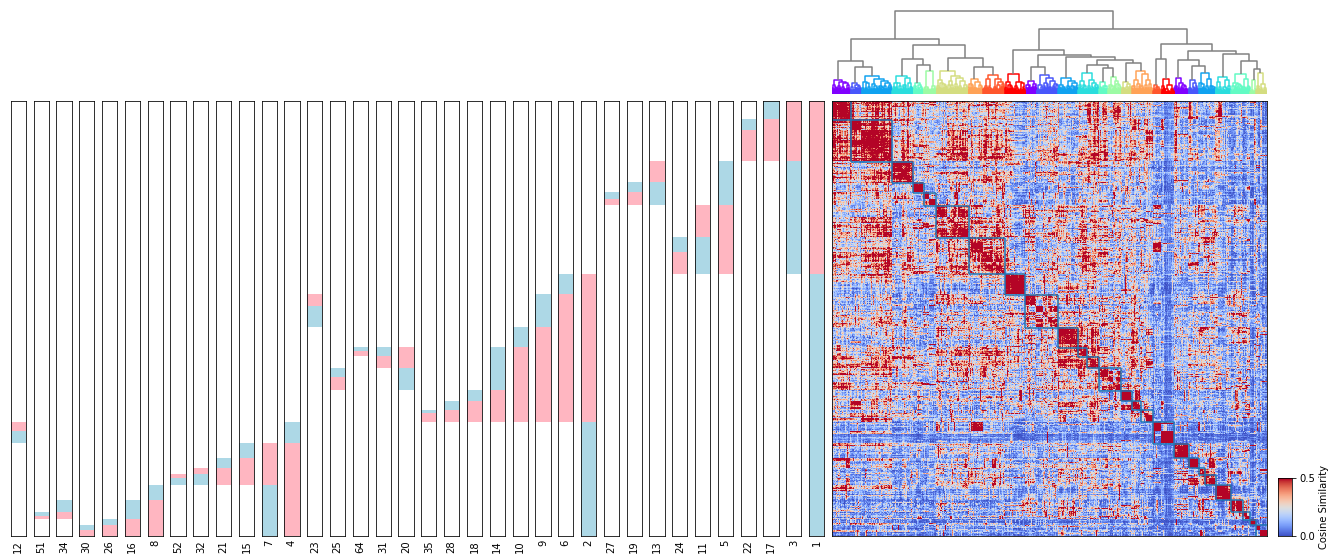

In [15]:
N_CLUSTERS = 28
f,d,dres,d_linkage = pl.plot_cmatrix(
    corr_raw_df, 
    n_clusters=N_CLUSTERS, 
    metas=[groups_df.fillna(-1)[x] for x in groups_df.columns],
    vmax=0.5,
    cbar_label='Cosine Similarity',
    metric='euclidean',
    method='ward',
    cmap='coolwarm',
    plot_cluster_lines=True,
    show_xlab=False,
    cdict_force={True:'lightpink', False:'lightblue', -1:'white'},
    input_clusters = np.array(groups_df.apply(lambda x: x.dropna().sort_index(ascending=False).index[0], 
                                              1).iloc[dres['leaves']].to_list())
)
plt.savefig("../notebook_outs/multiomic_signature_dendrogram_analysis/sample_sample_H_map_degroups.pdf",
            dpi=100,bbox_inches='tight')

In [36]:
groups_df.apply(lambda x: x.dropna().sort_index(ascending=False).index[0], 1).nunique()

26

In [43]:
clusters_s = groups_df.apply(lambda x: x.dropna().sort_index(ascending=False).index[0],
                             1).iloc[dres['leaves']]
clusters_l = list(clusters_s.unique())
cluster_label_d = {clusters_l[i]:f'C{i+1}' for i in range(len(clusters_l))}
cluster_id_df = pd.DataFrame(clusters_s.map(cluster_label_d)).rename(columns={0:"cluster_id"})
groups_df = groups_df.iloc[dres['leaves']]

In [31]:
groups_df = pd.read_csv("../notebook_outs/multiomic_signature_dendrogram_analysis/dendrogram_split_map.tsv", sep='\t', index_col=0)
cluster_id_df = pd.read_csv("../notebook_outs/multiomic_signature_dendrogram_analysis/cluster_map.tsv", sep='\t', index_col=0)


In [44]:
groups_df.to_csv("../notebook_outs/multiomic_signature_dendrogram_analysis/dendrogram_split_map.tsv", sep='\t')
groups_df.to_csv("gs://cptac-pancan-getzlab/Final_Submission_Files/Hierarchical_Clustering/dendrogram_split_map.tsv", 
                 sep='\t')
cluster_id_df.to_csv("../notebook_outs/multiomic_signature_dendrogram_analysis/cluster_map.tsv", sep='\t')
cluster_id_df.to_csv("gs://cptac-pancan-getzlab/Final_Submission_Files/Hierarchical_Clustering/cluster_map.tsv", 
                 sep='\t')

## 3. Statistical tests on non-overlapping clusters

Rank-sum test of NMF signature weights between the two superclusters of the first dendrogram spliot

In [5]:
# Load data
cluster_id_df = pd.read_csv(
    "gs://cptac-pancan-getzlab/Final_Submission_Files/Hierarchical_Clustering/cluster_map.tsv", 
    sep='\t', index_col=0)
groups_df = pd.read_csv(
    "gs://cptac-pancan-getzlab/Final_Submission_Files/Hierarchical_Clustering/dendrogram_split_map.tsv", 
    sep='\t', index_col=0)
h_raw_df = pd.read_hdf(NMF_PATH, "Hraw")

In [6]:
# Rank sum test of NMF weights for first dendrogram split
left_samples_s = groups_df[groups_df['1']==True].index
right_samples_s = groups_df[groups_df['1']==False].index
dendro_stats_df = pd.DataFrame(index=h_raw_df.index, columns = ['stat', 'pval'])
for signature in h_raw_df.index:
    stat, pval = ranksums(h_raw_df.loc[signature, left_samples_s], h_raw_df.loc[signature, right_samples_s])
    dendro_stats_df.loc[signature, 'stat'] = stat
    dendro_stats_df.loc[signature, 'pval'] = pval
# dendro_stats_df.to_csv("../notebook_outs/dendrosplit_1_nmf_signatures.tsv", sep='\t')
dendro_stats_df.sort_values('pval')


,stat,pval
S8,17.3283,2.87852e-67
S14,-12.2898,1.0277e-34
S22,-11.448,2.4053e-30
S1,10.7258,7.69987e-27
S11,9.02959,1.7231e-19
S12,8.73753,2.38255e-18
S24,-8.24034,1.7172e-16
S20,7.87761,3.33707e-15
S23,-6.23369,4.55573e-10
S10,-5.02213,5.11026e-07


Text(0.6, 0.75, 'p-value: 2.9e-67')

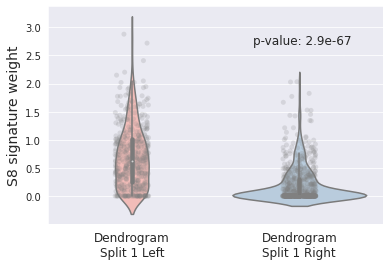

In [22]:
s8_df = h_raw_df.T[['S8']]
s8_df['Dendrogram Split 1 membership'] = s8_df.index.map(
    lambda x: 'Dendrogram Split 1 Left' if dendrogram_df.loc[x,'1']==True else 
    "Dendrogram Split 1 Right"
)
f, ax = plt.subplots(1, 1, figsize=(6,4))
sns.set_style("darkgrid")
sns.violinplot(data=s8_df, x='Dendrogram Split 1 membership', 
               y='S8', palette="Pastel1", 
               ax=ax)
sns.stripplot(data=s8_df, x='Dendrogram Split 1 membership', 
              y='S8', alpha=0.2, color='grey', 
              ax=ax)
ax.set_ylabel("S8 signature weight", size=14)
ax.set_xlabel("")
ax.axes.set_xticklabels(["Dendrogram\nSplit 1 Left", "Dendrogram\nSplit 1 Right"], size=12)
f.text(s=f"p-value: {dendro_stats_df.loc['S8','pval']:.1e}", y=0.75, x=0.6, size=12)